In [2]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


c:\Users\Napat\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

groundtruth_texts = {
    "Text1": (
        "Today is our Dragon Boat Festival. In our Chinese culture, we celebrate it with the wish for safety and prosperity in "
        "all aspects of our lives. I hope you also enjoy it, as are my deepest wishes for you."
        "Thank you for your message; I will convey our words to the doctor regarding his next contract check-up for all of us."
        "I received this message as an approved confirmation. In fact, I had already received a similar message from the professor "
        "a couple of days ago. I deeply appreciate the professor's full support for our Springer proceedings publication."
    ),
    "Text2": (
        "During our final discussion, I told him about the new submission—the one we had been waiting for since last autumn. "
        "However, the updates were confusing as they did not include the full feedback from the reviewer, or perhaps the editor?"
        "Anyway, I believe the team, although a bit delayed and with less communication in recent days, truly tried their best for "
        "the paper and our cooperation. We should all be grateful for the acceptance and efforts, leading up to the Springer link "
        "finally appearing last week, I think. Also, please kindly remind me if the doctor still plans to edit the acknowledgments "
        "section before sending it again. I did not see that part finalized yet, or perhaps I missed it; I apologize if so. "
        "Overall, let us ensure everyone is safe and celebrate the outcome with strong coffee and future targets."
    )
}

reconstructed_texts = {
    "Text1": {
        "Pipeline1": "Today is our dragon boat festival in our Chinese culture to celebrate it with all safety and greatness in our lives. Hope you too, enjoy it as my deepest wishes. Thank you for your message to show our words to the doctor, as his next contract checking, to all of us. I got this message to see the approved message. In fact, a couple of days ago I received the message from the professor to show me this. I am very grateful for the full support of the professor for the publication of our Springer proceedings.",
        "Pipeline2": "Our Chinese culture has a dragon boat festival that is celebrated today. Hope you enjoy it as much as I did. Your message was appreciated by the doctor, as his next contract checks, to all of us. I received the message to see the approved one. I received the message from the professor a couple of days ago. I would like to thank the professor for his full support of the Springer proceedings publication.",
        "Pipeline3": "Today, we celebrate the Dragon Boat Festival, a significant event in Chinese culture that honors the importance of safety and well-being in our lives. I sincerely hope you enjoy it as much as I do. Thank you for your message. We will present it to the doctor as part of his review of the upcoming contract for our team. I received this message to review the approved content. I received a message from the professor a couple of days ago regarding this matter. I sincerely appreciate the professor's invaluable support for our publication in the Springer proceedings."
    },
    "Text2": {
        "Pipeline1": "During our final discussion, I told him about the new submission — the one we had been waiting for since last autumn — but the updates were confusing as it did not include the full feedback from the reviewer or maybe the editor? Anyway, I believe that the team, although a bit delayed and less communicative in recent days, really tried their best for the paper and our cooperation. We should be grateful, I mean all of us, for the acceptance and efforts until the Springer link finally came last week, I think. Please also remind me if the doctor still plans to edit the acknowledgments section before he sends again. Because I didn’t see that part final yet, or maybe I missed it, I apologize if so. Let us make sure that all are safe and celebrate the outcome with strong coffee and future goals.",
        "Pipeline2": "I told him about the new submission we were waiting for since last autumn, but the updates were confusing as it did not include the full feedback from reviewer or editor. I think the team tried their best for paper and cooperation despite the recent delay and less communication. We should be thankful for the acceptance and efforts until the Springer link came last week, I think. If the doctor still plans for the acknowledgments section to be edited before he sends again, please remind me. I apologize if I missed that part final. Let's make sure all are safe and celebrate the outcome with coffee and targets.",
        "Pipeline3": "In our final discussion, I informed him about the new submission that we had been awaiting since last autumn. However, the updates were unclear, as they did not include the complete feedback from either the reviewer or the editor. I believe the team, despite some recent delays and limited communication, has made a commendable effort in their work on the paper and in fostering collaboration. We should all express our gratitude for the acceptance and the efforts made until the Springer link was finally received last week. Could you please remind me if the doctor still plans to edit the acknowledgments section before resending it? Thank you. I apologize if I overlooked that part, as I have not yet seen the final version. Let's ensure everyone's safety while we celebrate our achievements with strong coffee and set our sights on future goals."
    }
}

# Φόρτωση BERT tokenizer και μοντέλου

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

#  Συνάρτηση για sentence embedding (average pooling)

In [7]:

def get_sentence_embedding(text: str) -> np.ndarray:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state  # shape: (1, seq_len, hidden_dim)
        sentence_emb = hidden_states.mean(dim=1).squeeze().numpy()  # shape: (hidden_dim,)
    return sentence_emb

# Υπολογισμός embeddings & cosine similarity

In [8]:

results = []
embeddings = {}

for text_id, groundtruth_text in groundtruth_texts.items():
    embeddings[text_id] = {}
    emb_gt = get_sentence_embedding(groundtruth_text)
    embeddings[text_id]["GroundTruth"] = emb_gt
    
    for pipe_id, rec_text in reconstructed_texts[text_id].items():
        emb_rec = get_sentence_embedding(rec_text)
        embeddings[text_id][pipe_id] = emb_rec
        sim_score = cosine_similarity(emb_gt.reshape(1, -1), emb_rec.reshape(1, -1))[0][0]
        results.append({"Text": text_id, "Pipeline": pipe_id, "CosineSimilarity": sim_score})

# Δημιουργία DataFrame με cosine similarity
cosine_df = pd.DataFrame(results)
print(cosine_df)

    Text   Pipeline  CosineSimilarity
0  Text1  Pipeline1          0.963393
1  Text1  Pipeline2          0.956642
2  Text1  Pipeline3          0.973577
3  Text2  Pipeline1          0.984293
4  Text2  Pipeline2          0.970071
5  Text2  Pipeline3          0.975597


# PCA Visualization (Token-Level) για Text1 vs Pipeline1

In [9]:

# Χρησιμοποιούμε την πρώτη πρόταση του Text1
sentence_gt = groundtruth_texts["Text1"].split(".")[0] + "."
sentence_rec = reconstructed_texts["Text1"]["Pipeline1"].split(".")[0] + "."

# Απλοϊκή tokenization (αφαίρεση στίξης + split)
def tokenize_simple(text: str):
    cleaned = text.replace(",", "").replace(".", "")
    return cleaned.split()

tokens_gt = tokenize_simple(sentence_gt)
tokens_rec = tokenize_simple(sentence_rec)

# Συνάρτηση για token embedding (χρησιμοποιώντας [CLS])
def get_token_embedding(token: str) -> np.ndarray:
    inputs = tokenizer(token, return_tensors="pt", truncation=True, max_length=10)
    with torch.no_grad():
        outputs = model(**inputs)
        emb = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return emb

# Υπολογισμός embeddings για κάθε token
embeds_gt = np.array([get_token_embedding(tok) for tok in tokens_gt])
embeds_rec = np.array([get_token_embedding(tok) for tok in tokens_rec])

# Συνδυασμός embeddings και δημιουργία labels
embeds_combined = np.vstack((embeds_gt, embeds_rec))
labels = ["GroundTruth"] * len(tokens_gt) + ["Reconstructed"] * len(tokens_rec)
tokens_combined = tokens_gt + tokens_rec

# PCA (2D)
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeds_combined)

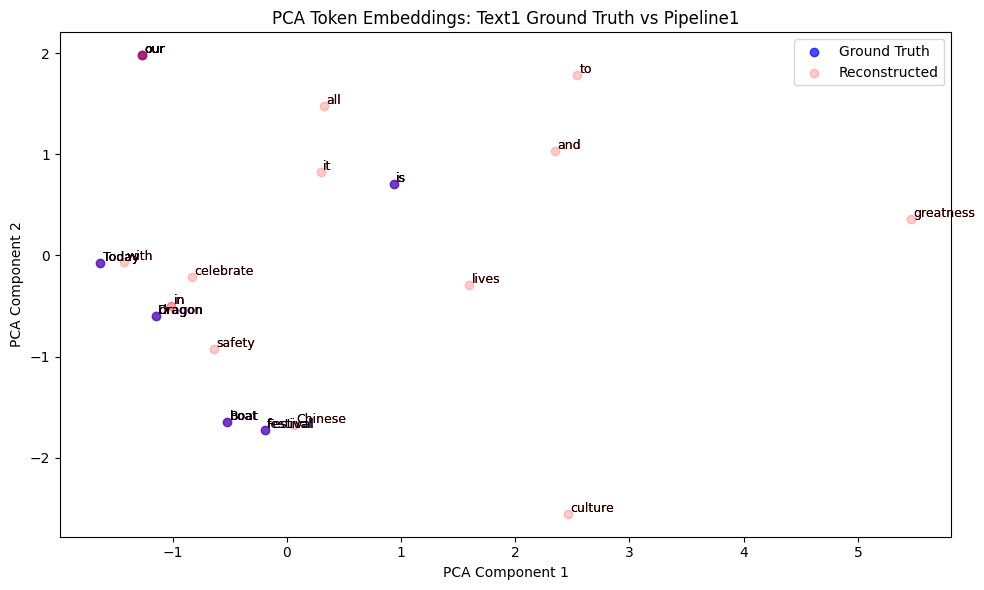

In [11]:
plt.figure(figsize=(10, 6))

# Χρώματα και labels
for i, (x, y) in enumerate(embeds_pca):
    label = labels[i]
    token = tokens_combined[i]
    if label == "GroundTruth":
        if label == "GroundTruth" and "Ground Truth" not in plt.gca().get_legend_handles_labels()[1]:
            plt.scatter(x, y, color="blue", alpha=0.7, label="Ground Truth")
        else:
            plt.scatter(x, y, color="blue", alpha=0.7)
        plt.text(x + 0.02, y + 0.02, token, fontsize=9, color="blue")
    else:
        plt.scatter(x, y, color="red", alpha=0.2, label="Reconstructed" if i == len(tokens_gt) else "")
        plt.text(x + 0.02, y + 0.02, token, fontsize=9, color="red")


for i, tok in enumerate(tokens_combined):
    plt.text(embeds_pca[i, 0] + 0.02, embeds_pca[i, 1] + 0.02, tok, fontsize=9)

plt.title("PCA Token Embeddings: Text1 Ground Truth vs Pipeline1")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
handles, labels_unique = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_unique, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()